In [ ]:
!unzip "/content/drive/MyDrive/HW3_Q1/satellite-images-of-water-bodies.zip"

unzip:  cannot find or open /content/drive/MyDrive/HW3_Q1/satellite-images-of-water-bodies.zip, /content/drive/MyDrive/HW3_Q1/satellite-images-of-water-bodies.zip.zip or /content/drive/MyDrive/HW3_Q1/satellite-images-of-water-bodies.zip.ZIP.


In [ ]:
from tensorflow import keras
from transformers import TFSamModel, SamProcessor
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.python.ops.numpy_ops import np_config
from PIL import Image
import requests
import glob
import os
import albumentations as A


In [ ]:

sam_model = SamModel.from_pretrained("facebook/sam-vit-base").to(device)
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

NameError: ignored

In [ ]:
!unzip "/content/drive/MyDrive/HW3_Q1/satellite-images-of-water-bodies.zip"

In [ ]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt

# Path to the main folder
main_folder = '/content/Water Bodies Dataset'

# Subfolders
images_folder = os.path.join(main_folder, 'Images')
mask_folder = os.path.join(main_folder, 'Masks')

# Get a list of files in each subfolder
images_files = os.listdir(images_folder)
mask_files = os.listdir(mask_folder)

# Shuffle the lists to ensure randomness in the pairs
random.shuffle(images_files)
# Display pairs of images and masks
num_samples = 8 # Change this number to display more or fewer samples
sample_images = images_files[:num_samples]

plt.figure(figsize=(15, 5 * num_samples))
for i in range(num_samples):
    img_path = os.path.join(images_folder, sample_images[i])
    mask_path = os.path.join(mask_folder, sample_images[i])

    img = Image.open(img_path)
    mask = Image.open(mask_path)

    plt.subplot(num_samples, 2, 2 * i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title('Image ' + str(i + 1))

    plt.subplot(num_samples, 2, 2 * i + 2)
    plt.imshow(mask)
    plt.axis('off')
    plt.title('Mask ' + str(i + 1))

plt.tight_layout()
plt.show()


In [ ]:
import os
import glob
import numpy as np
from PIL import Image
import albumentations as A

class Generator:
    """Generator class for processing the images and the masks for SAM fine-tuning."""

    def __init__(self, image_path,mask_path, processor, augmentation=None):
        self.dataset_path = image_path
        self.image_paths = image_path
        self.label_paths = mask_path
        self.processor = processor
        self.augmentation = augmentation

    def __call__(self):
        for image_path, label_path in zip(self.image_paths, self.label_paths):
            image = np.array(Image.open(image_path).resize((256, 256)))
            ground_truth_mask = np.array(Image.open(label_path).convert("L").resize((256, 256)))

            if self.augmentation:
                augmented = self.augmentation(image=image, mask=ground_truth_mask)
                image = augmented['image']
                ground_truth_mask = augmented['mask']

            # get bounding box prompt
            prompt = self.get_bounding_box(ground_truth_mask)

            # prepare image and prompt for the model
            inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="np")

            # remove batch dimension which the processor adds by default
            inputs = {k: v.squeeze(0) for k, v in inputs.items()}

            # add ground truth segmentation
            inputs["ground_truth_mask"] = ground_truth_mask

            yield inputs

    def __len__(self):
        return len(self.image_paths)  # Return the number of images in the dataset
    def get_bounding_box(self,ground_truth_map):
        #print(ground_truth_map.shape, type(ground_truth_map))
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)

        # Check if there are valid indices
        if len(x_indices) > 0 and len(y_indices) > 0:
            x_min, x_max = np.min(x_indices), np.max(x_indices)
            y_min, y_max = np.min(y_indices), np.max(y_indices)
            # add perturbation to bounding box coordinates
            H, W = ground_truth_map.shape
            x_min = max(0, x_min - np.random.randint(0, 20))
            x_max = min(W, x_max + np.random.randint(0, 20))
            y_min = max(0, y_min - np.random.randint(0, 20))
            y_max = min(H, y_max + np.random.randint(0, 20))
            bbox = [x_min, y_min, x_max, y_max]
        else:
            # If no valid indices found, set default bounding box
            bbox = [0, 0, 0, 0]  # Set default values

        return bbox


In [ ]:
# Define the output signature of the generator class.
output_signature = {
    "pixel_values": tf.TensorSpec(shape=(3, None, None), dtype=tf.float32),
    "original_sizes": tf.TensorSpec(shape=(None,), dtype=tf.int64),
    "reshaped_input_sizes": tf.TensorSpec(shape=(None,), dtype=tf.int64),
    "input_boxes": tf.TensorSpec(shape=(None, None), dtype=tf.float64),
    "ground_truth_mask": tf.TensorSpec(shape=(None, None), dtype=tf.int32),
}
dataset_path="/content/Water Bodies Dataset"
# Prepare the dataset object.
aug = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=1),
    A.RandomResizedCrop(256, 256, scale=(0.8, 1.0), p=0.5),
    # Add more transformations as needed
])

# Initialize Generator with augmentation
train_dataset_gen = Generator(dataset_path, processor)

train_ds = tf.data.Dataset.from_generator(
    train_dataset_gen, output_signature=output_signature
)

2841


In [ ]:
from sklearn.model_selection import train_test_split

# Get the list of image and label paths
image_paths = sorted(glob.glob(os.path.join(dataset_path, "Images/*.jpg")))
label_paths = sorted(glob.glob(os.path.join(dataset_path, "Masks/*.jpg")))

# Split the data into train and test sets (adjust the test_size as needed)
train_image_paths, test_image_paths, train_label_paths, test_label_paths = train_test_split(
    image_paths, label_paths, test_size=0.2, random_state=42
)

# Create generators for train and test sets
train_dataset_gen = Generator(train_image_paths, train_label_paths, processor, augmentation=aug)
test_dataset_gen = Generator(test_image_paths, test_label_paths, processor)

# Convert to TensorFlow Datasets
train_ds = tf.data.Dataset.from_generator(
    train_dataset_gen, output_signature=output_signature
)
test_ds = tf.data.Dataset.from_generator(
    test_dataset_gen, output_signature=output_signature
)
auto = tf.data.AUTOTUNE
batch_size = 2
shuffle_buffer = 1
# Apply shuffling, batching, and prefetching to both train and test datasets
train_ds = (
    train_ds
    .shuffle(shuffle_buffer)
    .batch(batch_size)
    .prefetch(buffer_size=auto)
)

test_ds = (
    test_ds
    .batch(batch_size)
    .prefetch(buffer_size=auto)
)


In [ ]:

def dice_loss(y_true, y_pred, smooth=1e-5):
    y_pred = tf.sigmoid(y_pred)
    reduce_axis = list(range(2, len(y_pred.shape)))
    if batch_size > 1:
        # reducing spatial dimensions and batch
        reduce_axis = [0] + reduce_axis
    intersection = tf.reduce_sum(y_true * y_pred, axis=reduce_axis)
    y_true_sq = tf.math.pow(y_true, 2)
    y_pred_sq = tf.math.pow(y_pred, 2)

    ground_o = tf.reduce_sum(y_true_sq, axis=reduce_axis)
    pred_o = tf.reduce_sum(y_pred_sq, axis=reduce_axis)
    denominator = ground_o + pred_o
    # calculate DICE coefficient
    loss = 1.0 - (2.0 * intersection + 1e-5) / (denominator + 1e-5)
    loss = tf.reduce_mean(loss)

    return loss


In [ ]:
# initialize SAM model and optimizer
sam = TFSamModel.from_pretrained("facebook/sam-vit-base")
optimizer = keras.optimizers.Adam(1e-5)

for layer in sam.layers:
    if layer.name in ["vision_encoder", "prompt_encoder"]:
        layer.trainable = False

All model checkpoint layers were used when initializing TFSamModel.

All the layers of TFSamModel were initialized from the model checkpoint at facebook/sam-vit-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFSamModel for predictions without further training.


In [ ]:
from tqdm import tqdm
import numpy as np
import tensorflow as tf
def calculate_iou(prediction, target):
    # Convert the tensors to boolean type
    prediction = tf.cast(prediction, dtype=tf.bool)
    target = tf.cast(target, dtype=tf.bool)

    intersection = tf.reduce_sum(tf.cast(tf.logical_and(target, prediction), dtype=tf.float32))
    union = tf.reduce_sum(tf.cast(tf.logical_or(target, prediction), dtype=tf.float32))
    iou = intersection / union
    return iou

def calculate_dice_coefficient(prediction, target):
    # Convert the tensors to boolean type
    prediction = tf.cast(prediction, dtype=tf.bool)
    target = tf.cast(target, dtype=tf.bool)

    intersection = tf.reduce_sum(tf.cast(tf.logical_and(target, prediction), dtype=tf.float32))
    dice_coefficient = (2.0 * intersection) / (tf.reduce_sum(tf.cast(target, dtype=tf.float32)) + tf.reduce_sum(tf.cast(prediction, dtype=tf.float32)))
    return dice_coefficient



@tf.function
def train_step(inputs):
    with tf.GradientTape() as tape:
        # pass inputs to SAM model
        outputs = sam(
            pixel_values=inputs["pixel_values"],
            input_boxes=inputs["input_boxes"],
            multimask_output=False,
            training=True,
        )

        predicted_masks = tf.squeeze(outputs.pred_masks, 1)
        ground_truth_masks = tf.cast(inputs["ground_truth_mask"], tf.float32)

        # calculate loss over predicted and ground truth masks

        loss = dice_loss(tf.expand_dims(ground_truth_masks, 1), predicted_masks)

        iou = calculate_iou(tf.expand_dims(ground_truth_masks, 1), predicted_masks)
        dice = calculate_dice_coefficient(tf.expand_dims(ground_truth_masks, 1), predicted_masks)
        # update trainable variables
        trainable_vars = sam.trainable_variables
        grads = tape.gradient(loss, trainable_vars)
        optimizer.apply_gradients(zip(grads, trainable_vars))

        return loss,iou,dice


In [ ]:
batch_iou.numpy()

0.5419235

In [ ]:
epochs = 3

for epoch in range(epochs):
    epoch_loss = 0.0
    epoch_iou = 0.0
    epoch_dice = 0.0

    with tqdm(total=2841, desc=f'Epoch {epoch + 1}/{epochs}', unit='batch') as progress_bar:
        for inputs in train_ds:
            batch_loss, batch_iou, batch_dice = train_step(inputs)
            epoch_iou += batch_iou.numpy()
            epoch_dice += batch_dice.numpy()
            epoch_loss += batch_loss

            # Update the progress bar with the current batch loss, IoU, and Dice coefficient
            progress_bar.set_postfix(loss=batch_loss, IoU=batch_iou.numpy(), DiceCoefficient=batch_dice.numpy())
            progress_bar.update()

    # Calculate and print the average loss, IoU, and Dice coefficient for the epoch
    average_loss = epoch_loss / len(train_ds)
    average_iou = epoch_iou / len(train_ds)
    average_dice = epoch_dice / len(train_ds)
    print(f"Epoch {epoch + 1}: Average Loss = {average_loss:.4f}, Average IoU = {average_iou:.4f}, Average Dice Coefficient = {average_dice:.4f}")


Epoch 1/3:   0%|          | 1/2841 [02:06<99:39:58, 126.34s/batch, DiceCoefficient=0.318, IoU=0.189, loss=tf.Tensor(0.99147636, shape=(), dtype=float32)]


KeyboardInterrupt: ignored

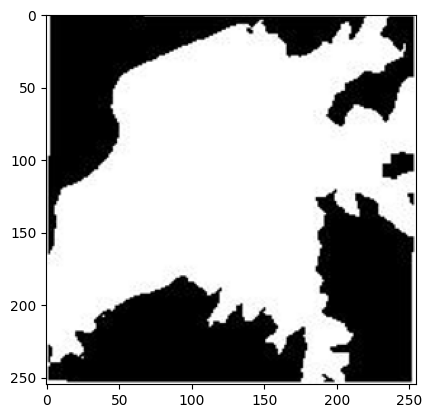

In [ ]:
# Load another image for inference.
idx = 12
image_paths = test_image_paths
label_paths = test_label_paths
raw_image_inference = Image.open(image_paths[idx]).resize((255,255))
raw_mask = Image.open(label_paths[idx]).resize((255,255))
plt.imshow(np.array(raw_mask))
#plt.imshow(np.array(raw_image_inference))
# process the image and infer
preprocessed_img = processor(raw_image_inference)
outputs = sam(preprocessed_img)

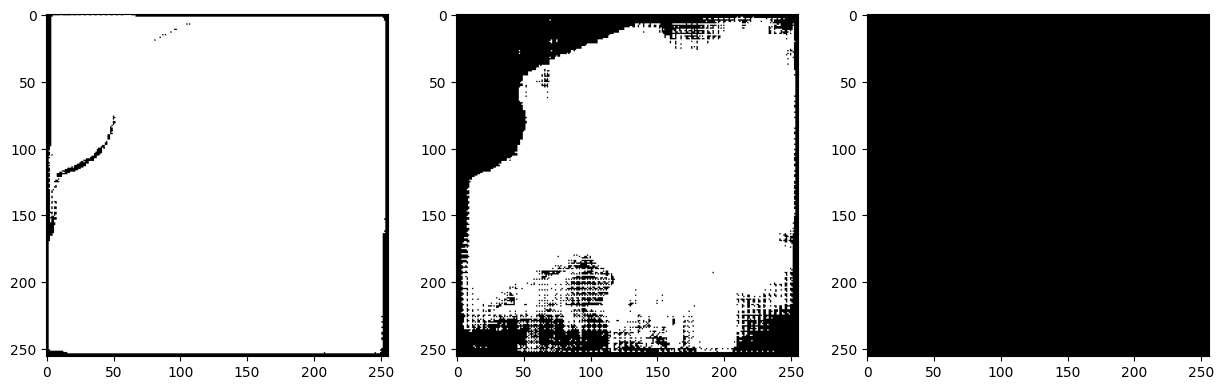

In [ ]:
idx = 12
image_paths = test_image_paths
label_paths = test_label_paths
raw_image_inference = Image.open(image_paths[idx]).resize((255,255))
raw_mask = Image.open(label_paths[idx]).resize((255,255))
plt.imshow(np.array(raw_mask))
#plt.imshow(np.array(raw_image_inference))
# process the image and infer
preprocessed_img = processor(raw_image_inference)
outputs = sam(preprocessed_img)

def show_masks_on_image(raw_image, masks, scores):
    if len(masks[0].shape) == 4:
        final_masks = tf.squeeze(masks[0])
    if scores.shape[0] == 1:
        final_scores = tf.squeeze(scores)

    nb_predictions = scores.shape[-1]
    fig, axes = plt.subplots(1, nb_predictions, figsize=(15, 15))

    for i, (mask, score) in enumerate(zip(final_masks, final_scores)):
        mask = tf.stop_gradient((mask > 0.5).astype(np.uint8))
        # axes[i].imshow(np.array(raw_image))
        axes[i].imshow(mask,cmap='gray')
        # axes[i].title.set_text(f"Mask {i+1}, Score: {score.numpy().item():.3f}")
        # axes[i].axis("off")
    plt.show()

infer_masks = outputs["pred_masks"]
iou_scores = outputs["iou_scores"]
show_masks_on_image(raw_image_inference, masks=infer_masks, scores=iou_scores)

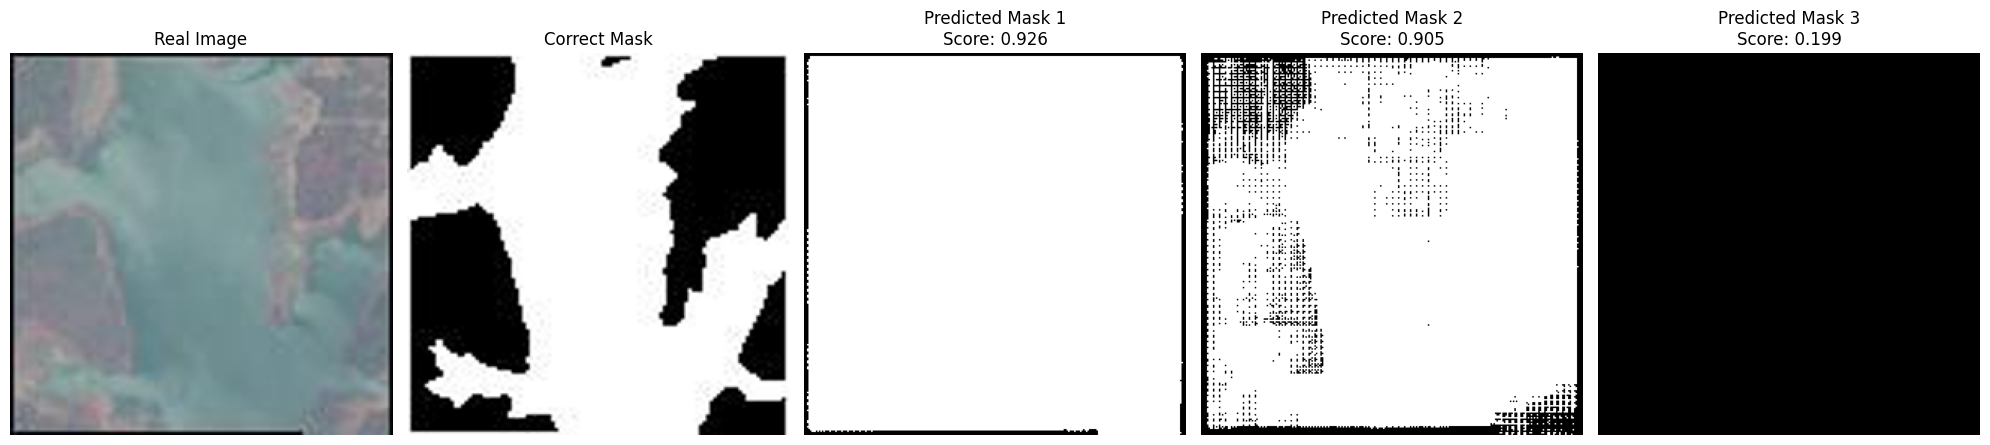

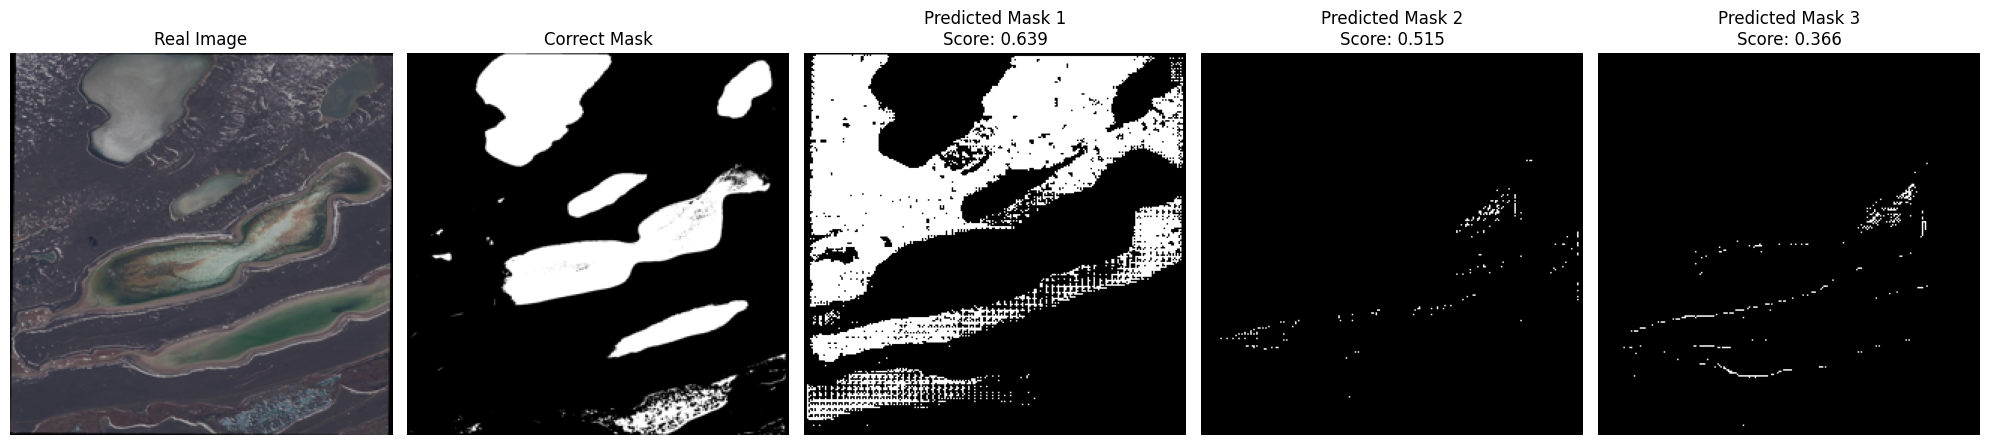

KeyboardInterrupt: ignored

In [ ]:
def display_images_with_masks(image_paths, label_paths, num_images=5):
    # Choose 5 random indices from the available image paths
    random_indices = np.random.choice(len(image_paths), num_images, replace=False)

    for idx in random_indices:
        # Load the real image and its corresponding mask
        raw_image = Image.open(image_paths[idx]).resize((255, 255))
        raw_mask = Image.open(label_paths[idx]).resize((255, 255))

        # Process the image and infer
        preprocessed_img = processor(raw_image)
        outputs = sam(preprocessed_img)

        infer_masks = outputs["pred_masks"]
        iou_scores = outputs["iou_scores"]

        if len(infer_masks[0].shape) == 4:
            final_masks = tf.squeeze(infer_masks[0])
        if iou_scores.shape[0] == 1:
            final_scores = tf.squeeze(iou_scores)

        nb_predictions = iou_scores.shape[-1]

        fig, axes = plt.subplots(1, nb_predictions + 2, figsize=(20, 8))

        # Display the real image
        axes[0].imshow(np.array(raw_image))
        axes[0].set_title('Real Image')
        axes[0].axis('off')

        # Display the correct mask
        axes[1].imshow(np.array(raw_mask), cmap='gray')
        axes[1].set_title('Correct Mask')
        axes[1].axis('off')

        for i in range(nb_predictions):
            mask = tf.stop_gradient((final_masks[i] > 0.5).numpy().astype(np.uint8))
            axes[i + 2].imshow(mask, cmap='gray')
            axes[i + 2].set_title(f"Predicted Mask {i+1}\nScore: {final_scores[i].numpy().item():.3f}")
            axes[i + 2].axis('off')

        plt.tight_layout()
        plt.show()

# Display real image, correct mask, and predicted masks for 5 random images
display_images_with_masks(test_image_paths, test_label_paths, num_images=5)
